In [1]:
import torch
import torchvision
import os
import numpy as np

In [2]:
data_dir = '/content/drive/My Drive/flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224),
                                            torchvision.transforms.RandomHorizontalFlip(p = 0.5),
                                            torchvision.transforms.RandomVerticalFlip(p = 0.2),
                                            torchvision.transforms.RandomRotation((-45, 45)),
                                            torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.ImageFolder(train_dir, transform = transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform = transform)

print (len(train_data))
print (len(test_data))

3139
540


In [4]:
batch_size = 20
num_workers = 0
indices = [i for i in range(0, len(train_data))]
np.random.shuffle(indices)
split = int(np.floor(0.8 * len(train_data)))
print(split)
train_idx, valid_idx = indices[:split], indices[split:]

2511


In [5]:
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

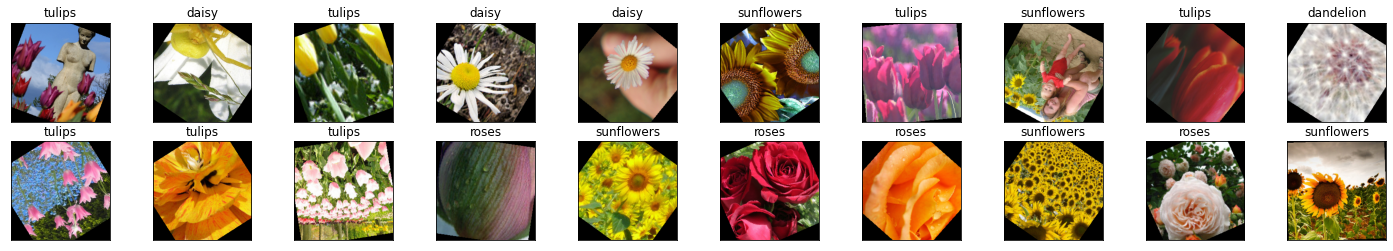

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx + 1, xticks = [], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(classes[labels[idx]])

In [7]:
model = torchvision.models.alexnet(pretrained = True)
print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [8]:
for param in model.features.parameters():
  param.requires_grad = False

In [9]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr = 0.001)

In [10]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))

model.classifier[6] = last_layer

model.cuda()
print (model.classifier[6].out_features)

5


In [11]:
n_epochs = 5

for epoch in range(1, n_epochs+1):
  train_loss = 0.0
  valid_loss = 0.0
  model.train()
  for data, target in train_loader:
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*data.size(0)
  
  model.eval()
  for data, target in valid_loader:
    data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    valid_loss += loss.item()*data.size(0)
  
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
  print("Epoch %d, Train Loss %.6f, Vaild Loss %.6f" %(epoch, train_loss, valid_loss))

Epoch 1, Train Loss 1.589528, Vaild Loss 1.381156
Epoch 2, Train Loss 1.270429, Vaild Loss 1.153502
Epoch 3, Train Loss 1.102928, Vaild Loss 1.040252
Epoch 4, Train Loss 1.001604, Vaild Loss 0.944454
Epoch 5, Train Loss 0.940970, Vaild Loss 0.891815


In [12]:
test_loss = 0.0
class_correct = list(0 for i in range(5))
class_total = list(0 for i in range(5))

model.eval()

for data, target in test_loader:
  data, target = data.cuda(), target.cuda()
  output = model(data)
  loss = criterion(output, target)
  test_loss += loss.item()*data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.cpu().numpy())
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print ('Test Loss {:.6f}'.format(test_loss))

Test Loss 0.859412


In [13]:
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of daisy: 65% (60/92)
Test Accuracy of dandelion: 87% (116/132)
Test Accuracy of roses: 37% (34/91)
Test Accuracy of sunflowers: 78% (79/101)
Test Accuracy of tulips: 73% (91/124)

Test Accuracy (Overall): 70% (380/540)
